In [12]:
import os

# Data
import pandas as pd
import numpy as np

from scipy.signal import savgol_filter

from ai_cdss.constants import *
from ai_cdss.processing import expand_session_batch, expand_session_batch_optimized

from utils import filter_study_range

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Eval
import time

## Data Setup

In [2]:
clinical_scores = pd.read_csv("data/nest_T01.csv")
clinical_scores['DIFF'] = clinical_scores['T1'] - clinical_scores['T0']
data = pd.read_parquet("data/nest_data.parquet")

In [3]:
data['SESSION_DATE'] = data['SESSION_DATE'].dt.normalize()
data['PRESCRIPTION_STARTING_DATE'] = data['PRESCRIPTION_STARTING_DATE'].dt.normalize()
data['PRESCRIPTION_ENDING_DATE'] = data['PRESCRIPTION_ENDING_DATE'].dt.normalize()
data_expanded = expand_session_batch_optimized(data)


study_data = data_expanded.groupby('PATIENT_ID', group_keys=False).apply(filter_study_range)
study_data['DAY_INDEX'] = study_data.groupby('PATIENT_ID')['SESSION_DATE'].transform(
    lambda x: (x - x.min()).dt.days
)
study_data = study_data[BY_ID + ["SESSION_DATE", "STATUS", "WEEKDAY_INDEX", "SECONDS_FROM_START"] + METRIC_COLUMNS + ["ADHERENCE", "PPF", "CONTRIB", "DAY_INDEX"]]
study_data = study_data.sort_values(by=["PATIENT_ID", "DAY_INDEX", "SESSION_ID", "SECONDS_FROM_START"])

/tmp/ipykernel_2310824/905491055.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  study_data = data_expanded.groupby('PATIENT_ID', group_keys=False).apply(filter_study_range)


In [4]:
def compute_metrics(
        df,
        alpha=0.5,
        window_size=7,
        scaling_factor = 2,
        min_window = 5,
        max_window = 21,
        polyorder=2,
        deriv=1,
        weights=[1,1,1]
    ):
    df = df.reset_index(drop=True)  # clean index for plotting
    df.sort_values(by=["SESSION_ID", "SECONDS_FROM_START"], inplace=True)
    
    # Compute smoothed dm
    df['DM_VALUE_EWMA'] = df['DM_VALUE'].ewm(alpha=alpha, adjust=True).mean()
    # Compute delta DM
    df['DELTA_DM'] = df['DM_VALUE'].diff().fillna(0)
    # Compute EWMA of DM
    df['DELTA_DM_EWMA'] = df['DELTA_DM'].ewm(alpha=alpha, adjust=True).mean()
    # Compute raw DM
    df['DELTA_DM_RAW'] = df['DM_VALUE'].diff().fillna(0)

    # Compute Savitzky-Golay filter of DM
    if window_size:
        window_length = window_size
    else:
        window_length = int(np.clip(1 / alpha * scaling_factor, min_window, max_window))
        if window_length % 2 == 0:
            window_length += 1  # ensure odd

    try:
        df['SG_DM'] = savgol_filter(df['DM_VALUE'], window_length=window_length, polyorder=polyorder, deriv=deriv)
    except ValueError:
        df['SG_DM'] = df['DM_VALUE']  # fallback: raw DM value

    # Compute score
    a = weights[0]
    b = weights[1]
    c = weights[2]
    df['CDSS_SCORE'] = a * df['PPF'] + b * df['DELTA_DM_EWMA'] + c * df['ADHERENCE']

    return df

In [5]:
# Aggregate metrics
result = (
    study_data
        .groupby(by=BY_PP)
        .apply(lambda x: compute_metrics(x, alpha=0.05))
        .reset_index(drop=True)
).sort_values(by=["PATIENT_ID", "DAY_INDEX", "SESSION_ID", "SECONDS_FROM_START"])
study_session = result.sort_values(by=BY_PP + ['SESSION_ID', 'SECONDS_FROM_START'])
study_session = study_session.drop_duplicates(subset=BY_PP + ['SESSION_ID'], keep='last')
study_session.sort_values(by=["PATIENT_ID", "DAY_INDEX", 'SESSION_ID', 'SECONDS_FROM_START'], inplace=True)

/tmp/ipykernel_2310824/1457505549.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: compute_metrics(x, alpha=0.05))


## Metrics

### Example

In [6]:
colors = {
    "CDSS Score": "#9b59b6",  # purple
    "Adherence": "#27ae60",  # green
    "Delta DM": "#e67e22",   # orange
    "DM Value": "#2980b9",   # blue
}

Plotting Patient 775, Protocol 206


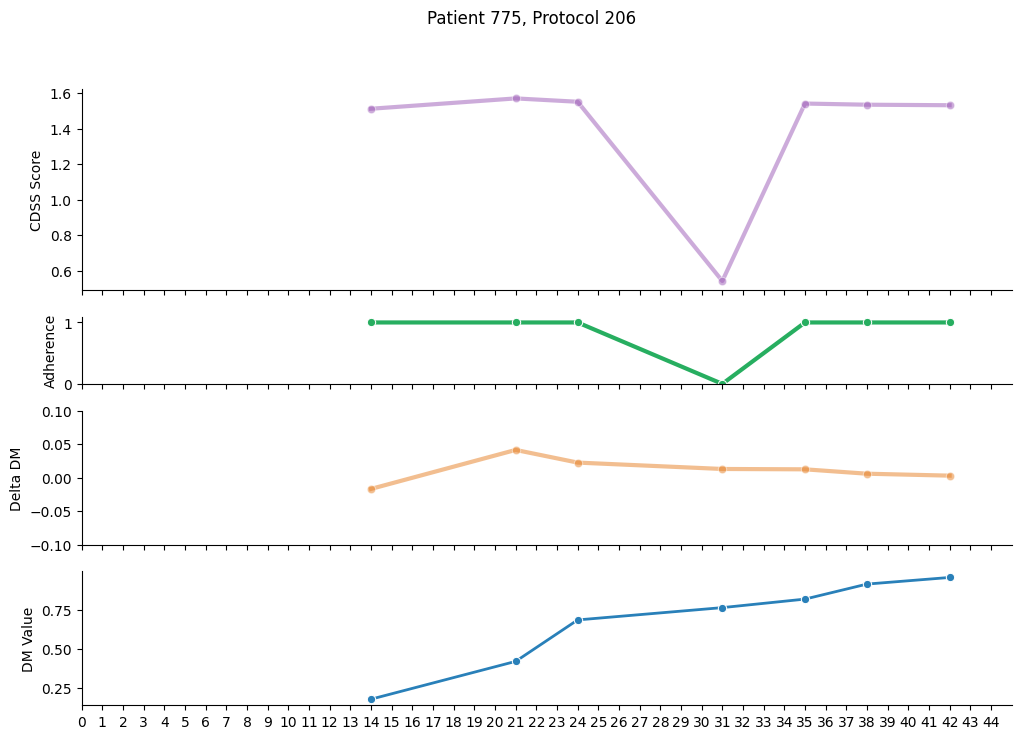

In [7]:
for i, g in study_session.groupby(by=BY_PP):
    df = g.reset_index(drop=True)

    patient_id = i[0]
    protocol_id = i[1]
    print(f"Plotting Patient {patient_id}, Protocol {protocol_id}")
    
    # Plotting
    fig = plt.figure(figsize=(12, 8))
    spec = gridspec.GridSpec(4, 1, height_ratios=[3, 1, 2, 2])  # 3/4 for DM, 1/4 for PE

    # --- CDSS: Score
    ax_cdss = fig.add_subplot(spec[0])
    sns.lineplot(data=df, x="DAY_INDEX", y='CDSS_SCORE', color=colors['CDSS Score'], marker='o', alpha=0.5, linewidth=3)
    ax_cdss.set_xlabel('')
    ax_cdss.set_ylabel('CDSS Score')
    ax_cdss.set_xlim(0, 45)
    ax_cdss.set_xticks(np.arange(0, 45, 1))
    ax_cdss.tick_params(labelbottom=False)
    ax_cdss.spines['top'].set_visible(False)
    ax_cdss.spines['right'].set_visible(False)

    # --- Adherence plot
    ax_ad = fig.add_subplot(spec[1], sharex=ax_cdss)
    sns.lineplot(data=df, x="DAY_INDEX", y='ADHERENCE', marker='o', color=colors['Adherence'], linewidth=3)
    ax_ad.set_ylim(0, 1.09)
    ax_ad.set_xlabel('')
    ax_ad.set_ylabel('Adherence')
    ax_ad.tick_params(labelbottom=False)
    ax_ad.spines['top'].set_visible(False)
    ax_ad.spines['right'].set_visible(False)

    # --- Delta DM
    ax_dm_delta = fig.add_subplot(spec[2], sharex=ax_cdss)
    sns.lineplot(data=df, x="DAY_INDEX", y='DELTA_DM_EWMA', color=colors['Delta DM'], marker='o', alpha=0.5, linewidth=3)
    ax_dm_delta.spines['top'].set_visible(False)
    ax_dm_delta.spines['right'].set_visible(False)
    ax_dm_delta.set_xlabel('')
    ax_dm_delta.set_ylabel('Delta DM')
    ax_dm_delta.set_ylim(-0.1, 0.1)
    ax_dm_delta.tick_params(labelbottom=False)

    # --- DM
    ax_dm = fig.add_subplot(spec[3], sharex=ax_cdss)
    sns.lineplot(data=df, x="DAY_INDEX", y='DM_VALUE_EWMA', color=colors['DM Value'], marker='o', alpha=1, linewidth=2)
    ax_dm.set_xlabel('')
    ax_dm.set_ylabel('DM Value')
    ax_dm.spines['top'].set_visible(False)
    ax_dm.spines['right'].set_visible(False)


    plt.suptitle(f'Patient {patient_id}, Protocol {protocol_id}', fontsize=12)
    break

### Generate Figures

### Generate Report

## Score

In [8]:
sns.set_theme(
    style="whitegrid",  # 'darkgrid', 'white', 'ticks'...
    palette="muted",    # you can still override per-plot
    rc={
        'lines.linewidth': 3,
        'lines.marker': '',
        'lines.markersize': 8,
        'font.size': 14,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'grid.linewidth': 0.5,
        'grid.alpha': 0.3,
        'errorbar.capsize': 5,  # default for all error bars
    }
)

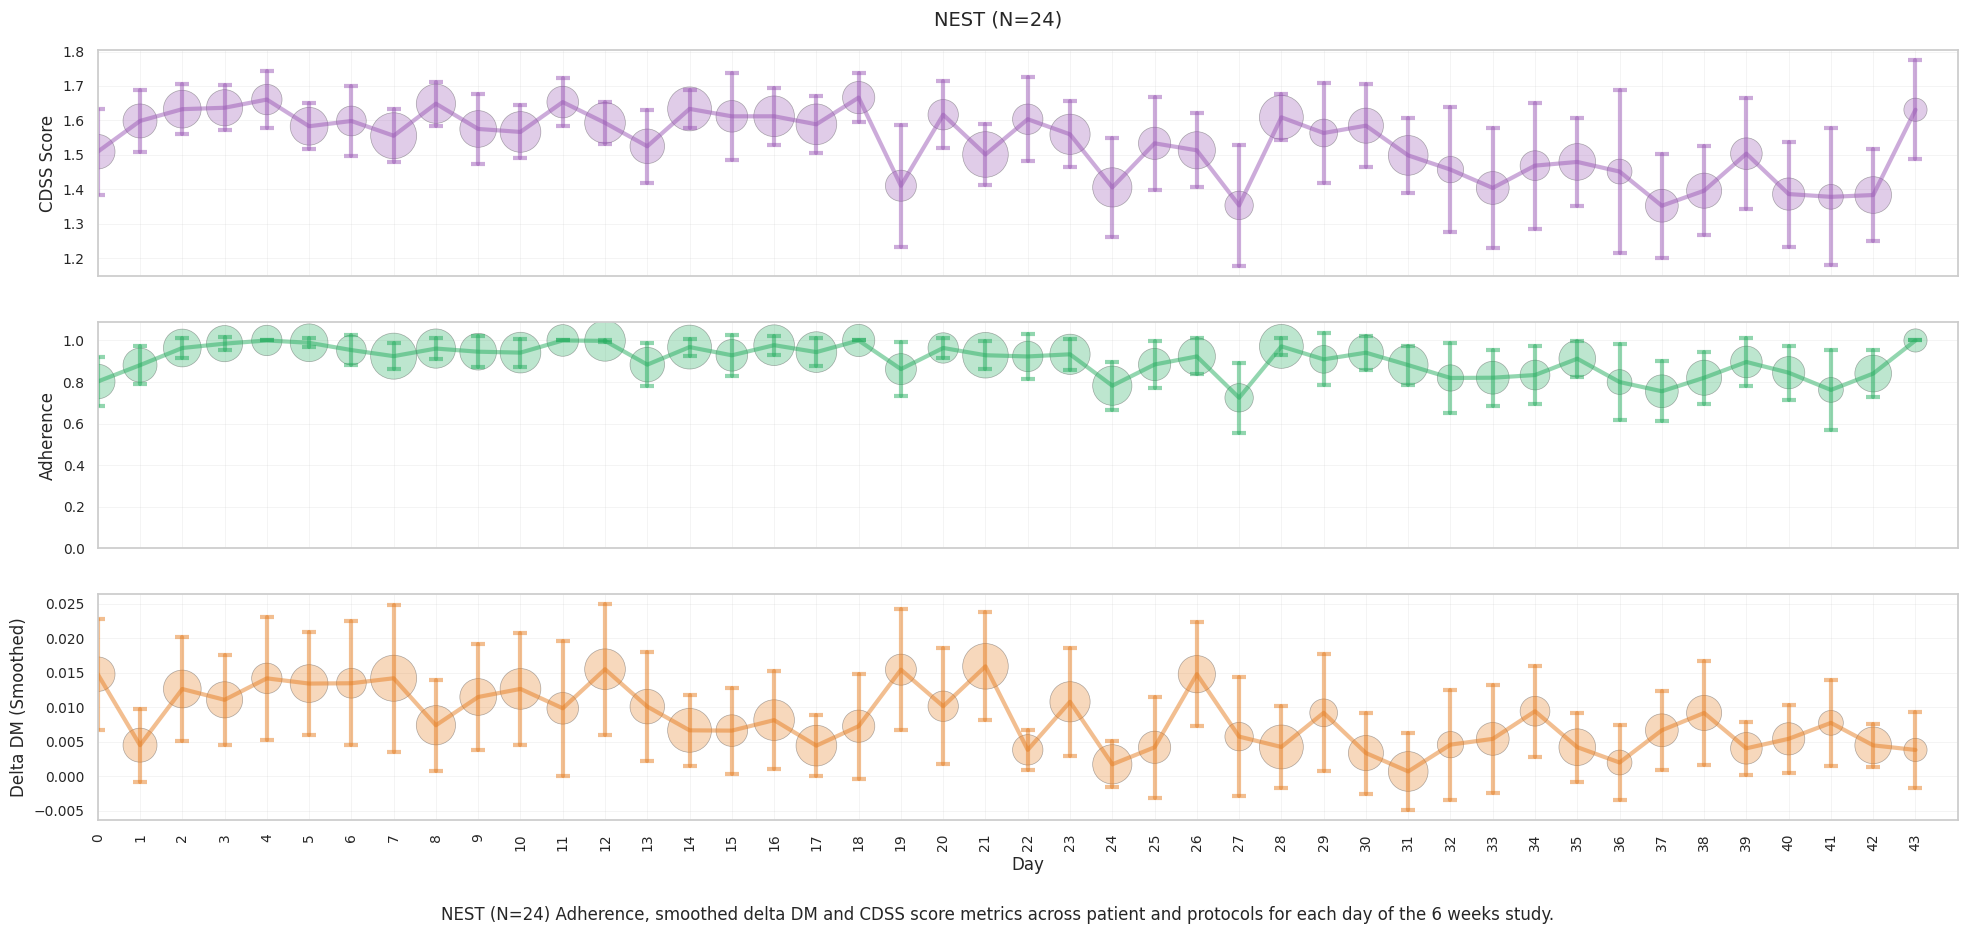

In [11]:
session_counts = study_session.groupby('DAY_INDEX')['SESSION_ID'].nunique().reset_index(name='SESSION_COUNT')
# Per-day means for each metric
daily_means = study_session.groupby('DAY_INDEX').agg({
    'CDSS_SCORE': 'mean',
    'ADHERENCE': 'mean',
    'DELTA_DM_EWMA': 'mean'
}).reset_index()

# Plotting
fig = plt.figure(figsize=(24, 10))
spec = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])  # 3/4 for DM, 1/4 for PE

# --- CDSS: Score

ax_cdss = fig.add_subplot(spec[0])
sns.lineplot(
    data=study_session,
    x='DAY_INDEX',
    y='CDSS_SCORE',
    color=colors['CDSS Score'],
    # marker='o',
    alpha=0.5,
    linewidth=3,
    legend=False,
    errorbar=('se', 2),
    err_style='bars',
    err_kws={'linewidth': 3, 'capthick': 3, 'capsize': 5},
)

ax_cdss.set_xlabel('')
ax_cdss.set_ylabel('CDSS Score')
ax_cdss.set_xlim(0, 44)
# ax_cdss.set_ylim(0.5, 1.09)
ax_cdss.set_xticks(np.arange(0, 44, 1))
ax_cdss.tick_params(labelbottom=False)

ax_adh = fig.add_subplot(spec[1], sharex=ax_cdss)
sns.lineplot(
    data=study_session,
    x='DAY_INDEX',
    y='ADHERENCE',
    color=colors['Adherence'],
    # marker='o',
    alpha=0.5,
    linewidth=3,
    legend=False,
    errorbar=('se', 2),
    err_style='bars',
    err_kws={'linewidth': 3, 'capthick': 3, 'capsize': 5},
)
ax_adh.set_xlabel('')
ax_adh.tick_params(labelbottom=False)
ax_adh.set_ylabel('Adherence')
ax_adh.set_ylim(0, 1.09)

ax_dm = fig.add_subplot(spec[2], sharex=ax_cdss)
sns.lineplot(
    data=study_session,
    x='DAY_INDEX',
    y='DELTA_DM_EWMA',
    color=colors['Delta DM'],
    # marker='o',
    alpha=0.5,
    linewidth=3,
    legend=False,
    errorbar=('se', 2),
    err_style='bars',
    err_kws={'linewidth': 3, 'capthick': 3, 'capsize': 5},
)
ax_dm.set_xlabel('Day')
ax_dm.set_ylabel('Delta DM (Smoothed)')
ax_dm.set_xticklabels(np.arange(0, 44, 1), rotation=90)


# Scatter: CDSS Score
ax_cdss.scatter(
    daily_means['DAY_INDEX'],
    daily_means['CDSS_SCORE'],
    s=session_counts['SESSION_COUNT'] * 20,
    color=colors['CDSS Score'],
    alpha=0.3,
    edgecolor='black',
    linewidth=0.5,
)

# Scatter: Adherence
ax_adh.scatter(
    daily_means['DAY_INDEX'],
    daily_means['ADHERENCE'],
    s=session_counts['SESSION_COUNT'] * 20,
    color=colors['Adherence'],
    alpha=0.3,
    edgecolor='black',
    linewidth=0.5,
)

# Scatter: Delta DM
ax_dm.scatter(
    daily_means['DAY_INDEX'],
    daily_means['DELTA_DM_EWMA'],
    s=session_counts['SESSION_COUNT'] * 20,
    color=colors['Delta DM'],
    alpha=0.3,
    edgecolor='black',
    linewidth=0.5,
)


fig.suptitle('NEST (N=24)', fontsize=14, y=0.92)
fig.text(0.5, 0.01, 'NEST (N=24) Adherence, smoothed delta DM and CDSS score metrics across patient and protocols for each day of the 6 weeks study.', 
         ha='center', fontsize=12)

plt.show()